<a href="https://colab.research.google.com/github/Nickimani/Airbnb_Project/blob/davis-eda/Airbnb_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Project

# 1. Business Understanding 

# 2. Data Understanding

# 3. Loading Data

## 3.1 Importing Libraries

In [1]:
# connecting to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# installing necessary libraries

!pip install reverse_geocoder # Reverse geoencoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 40.9 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=418673a114a4c1bbbec8eed12a2ee2c9625a8e33aac54bcf00c5d87aeb2bf045
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [3]:
# importing libraries

import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import reverse_geocoder as rg


%matplotlib inline

## 3.2 Loading The DataFrames

In [4]:
# creating the DataFrames

listings_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/listings.csv')
reviews_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/reviews.csv')
metadata_df = pd.read_csv('/content/drive/Shareddrives/CapStone/Data/data_dictionary.csv')

In [5]:
# a function returning the datastructure of a the input dataframe

def data_structure(dataframe, data_name):
    """ 
    Returns datashape and data info. 
    """
    print(f'{data_name} dataframe shape:', dataframe.shape)
    print('-'*120)
    print(dataframe.info())

# a function returning a dataframe of the completeness of the features in the input dataframe 

def percentage_completeness(dataframe):
    """
    Returns a dataframe showcasing the percentage completeness of the columns in a dataframe    
    """
    tot_entries = len(dataframe) # length of dataframe

    columns = list(dataframe.columns) # name of columns list
    perc_completeness = [] 

    for column in columns:
        missing = dataframe[column].isna().sum() # taking number of missing records
        perc_null_counts = (1 - (missing / tot_entries)) * 100 # calculating percentage of completeness in column
        perc_completeness.append(round(perc_null_counts, 2)) 

    output = pd.DataFrame(list(zip(columns, perc_completeness)), 
                          columns=['Feature', '%_completeness']) # creating dataframe of column and completeness
    output = output.sort_values(by='%_completeness', ascending=True) # sorting the values
    output.reset_index(inplace=True, drop=True)

    return output

# a function that pulls valuecounts from a column

def value_count(dataframe, column):
    """
    Returns the value counts for unique value in the column specified
    """
    val_count = dataframe[column].value_counts() # getting the value counts

    result = val_count.to_frame(name='Count(s)') # converting list output to dataframe

    return result

# removing the % sign from the strings
    
def strip_signs(dataframe, column):
    """
    Takes in a dataframe and the column to be cleaned. 
    The column should have a prefix of suffix that if removed,would make the column convertible to a numeric datatype
    Returns a replacement of the input column cleaned and converted to float dtype.
    """
    feature = pd.Series(dataframe[column]) # making sure its a series
    
    feature = feature.str.strip(to_strip='%') # striping % sign from string

    final_feature = feature.astype('float') # converting datatype

    return final_feature


# boxplot of a series

def box_plot(series):
    """
    Returns a boxplot of the column specified    
    """
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.boxplot(x=series, linewidth=1, palette='Set2') # creating a boxplot

    ax.set_title(f'{series.name}, Airbnb Cape town', fontsize=30,pad=30) # Give the plot a main title
    ax.set_xlabel(series.name, fontsize=20, labelpad=15) # Set text for the x axis,

    sns.despine(offset=5, left=True);

# Build a function for regex stripping maybe linked to strip signs


### Data Structure

In [6]:
# data_structure(listings_df, 'listing_df') # listings df structure

The listings dataFrame has 18903 rows with 74 columns. 41 of the columns are of numeric type and The remaining 33 are of object type.

In [7]:
# removing unnecessary columns
relevant_cols = ['id', 'listing_url', 'host_url', 'last_scraped', 'host_since', 'host_location', 
                 'neighbourhood_cleansed', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
                 'host_is_superhost', 'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 
                 'beds', 'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 
                 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
                 'review_scores_location', 'instant_bookable', 'calculated_host_listings_count']

# subsetting the relevant columns

listings_df = listings_df[relevant_cols]

In [8]:
data_structure(listings_df, 'listing_df') # new_listings df structure

listing_df dataframe shape: (18903, 29)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18903 entries, 0 to 18902
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18903 non-null  int64  
 1   listing_url                     18903 non-null  object 
 2   host_url                        18903 non-null  object 
 3   last_scraped                    18903 non-null  object 
 4   host_since                      18902 non-null  object 
 5   host_location                   18812 non-null  object 
 6   neighbourhood_cleansed          18903 non-null  object 
 7   host_response_time              14710 non-null  object 
 8   host_response_rate              14710 non-null  object 
 9   host_acceptance_rate            16542 non-null  object

In [9]:
data_structure(reviews_df, 'reviews_df') # reviews_df structure

reviews_df dataframe shape: (363065, 6)
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363065 entries, 0 to 363064
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     363065 non-null  int64 
 1   id             363065 non-null  int64 
 2   date           363065 non-null  object
 3   reviewer_id    363065 non-null  int64 
 4   reviewer_name  363065 non-null  object
 5   comments       363018 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.6+ MB
None


Reviews dataframe has only 1 column with nan values.
The nature of the comments column makes it difficult to fill the nan values.

In [10]:
# dropping nan values in reviews_df
reviews_df.dropna(inplace=True)

In [11]:
listings_df.head() # viewing listings df

,id,listing_url,host_url,last_scraped,host_since,host_location,neighbourhood_cleansed,host_response_time,host_response_rate,host_acceptance_rate,...,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,instant_bookable,calculated_host_listings_count
0,30332317,https://www.airbnb.com/rooms/30332317,https://www.airbnb.com/users/show/98554302,2022-06-22,2016-10-07,"Cape Town, Western Cape, South Africa",Ward 15,within an hour,100%,100%,...,"$1,350.00",2,5.00,5.0,5.0,5.0,5.0,5.00,t,7
1,9126484,https://www.airbnb.com/rooms/9126484,https://www.airbnb.com/users/show/3410651,2022-06-22,2012-08-29,"Cape Town, Western Cape, South Africa",Ward 61,within a few hours,100%,50%,...,"$1,750.00",15,4.87,5.0,5.0,5.0,5.0,4.93,f,1
2,44482125,https://www.airbnb.com/rooms/44482125,https://www.airbnb.com/users/show/98554302,2022-06-22,2016-10-07,"Cape Town, Western Cape, South Africa",Ward 15,within an hour,100%,100%,...,"$1,350.00",0,NaN,NaN,NaN,NaN,NaN,NaN,t,7
3,12105523,https://www.airbnb.com/rooms/12105523,https://www.airbnb.com/users/show/58287766,2022-06-22,2016-02-11,"Cape Town, Western Cape, South Africa",Ward 15,NaN,NaN,100%,...,"$1,436.00",0,NaN,NaN,NaN,NaN,NaN,NaN,t,5
4,14921766,https://www.airbnb.com/rooms/14921766,https://www.airbnb.com/users/show/58287766,2022-06-22,2016-02-11,"Cape Town, Western Cape, South Africa",Ward 15,NaN,NaN,100%,...,"$2,871.00",1,5.00,5.0,5.0,5.0,5.0,5.00,t,5


In [12]:
reviews_df.head() # viewing reviews df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,30332317,597314314,2020-01-25,7812767,Alan,Lovely rustic accommodation in a picturesque r...
1,30332317,532436007654450454,2022-01-04,367340518,Courtney,The hosts are friendly and takes good care of ...
2,9126484,63063726,2016-02-20,50272994,Carla,6 St Georges Building was lovely in every way....
3,9126484,67195563,2016-03-27,59937103,Gau,"Our host Bruce was great. Responsive, helpful ..."
4,9126484,68077701,2016-04-02,19226497,Imke,Bruce was incredibly welcoming and very flexib...


# 4. Exploratory Data Analysis

## 4.1 Listings DataFrame

**Questions?**

1. What factors, if any influence price?(Regression question)
2. What is the difference between a superhost and a non-superhost? (Classification question)
3. What are the factors unique to listings with above average ratings?

### 4.1.1 Univariate Analysis



#### 4.1.1.1 Completeness

In [13]:
listings_completeness = percentage_completeness(listings_df) # checking percentage null value counts in listings 

# filtering out columns with complete records
listings_completeness = listings_completeness[listings_completeness['%_completeness'] < 100] 
listings_completeness

,Feature,%_completeness
0,review_scores_location,71.97
1,review_scores_checkin,71.97
2,review_scores_communication,71.98
3,review_scores_accuracy,71.98
4,review_scores_cleanliness,71.99
5,review_scores_rating,72.79
6,host_response_rate,77.82
7,host_response_time,77.82
8,host_acceptance_rate,87.51
9,bedrooms,93.71


In [14]:
print('The number of columns with missing values are: ', len(listings_completeness[listings_completeness['%_completeness'] < 100]))

The number of columns with missing values are:  15


The columns neighbourhood_group_cleansed, license, bathrooms, calendar_updated and host_neighbourhood have the highest number of missing values with over 95% of the data missing. We don't think there is much we can do with this columns and we will look to drop them.

##### `'review'` 

Dealing with review_scores_checkin, review_scores_location, review_scores_value, review_scores_accuracy, review_scores_communication, review_scores_cleanliness & review_scores_ratings columns.

In [15]:
# Creating a list of the reviews_ columns

review_list = [column for column in listings_df.columns if 'review_score' in column.strip()]
review_list

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location']

In [16]:
review_cols_df = listings_df[review_list].copy() # subsetting a dataframe of review list

review_cols_df.isna().sum() # checking sum of nan values

review_scores_rating           5143
review_scores_accuracy         5296
review_scores_cleanliness      5295
review_scores_checkin          5299
review_scores_communication    5296
review_scores_location         5299
dtype: int64

In [17]:
review_cols_df.tail().T # Check tail of subset

,18898,18899,18900,18901,18902
review_scores_rating,4.79,5.0,4.8,5.0,4.59
review_scores_accuracy,4.95,5.0,4.8,5.0,4.77
review_scores_cleanliness,4.95,5.0,4.7,5.0,4.77
review_scores_checkin,4.89,5.0,4.8,5.0,4.55
review_scores_communication,4.89,4.0,4.7,5.0,4.73
review_scores_location,5.00,5.0,4.4,5.0,4.95


All columns are of numeric type.

In [18]:
review_cols_df.describe().T # checking the column descriptions

,count,mean,std,min,25%,50%,75%,max
review_scores_rating,13760.0,4.666231,0.684017,0.0,4.64,4.86,5.0,5.0
review_scores_accuracy,13607.0,4.757262,0.490736,0.0,4.73,4.91,5.0,5.0
review_scores_cleanliness,13608.0,4.730264,0.492878,0.0,4.67,4.89,5.0,5.0
review_scores_checkin,13604.0,4.808905,0.462444,0.0,4.81,4.97,5.0,5.0
review_scores_communication,13607.0,4.802807,0.479074,0.0,4.81,4.97,5.0,5.0
review_scores_location,13604.0,4.803673,0.414366,0.0,4.78,4.93,5.0,5.0


There is a significant percentage of missing values in some of the 'review' columns. The missing values will be filled with the median of the respective column.

In [19]:
# imputing missing values with median

listings_df[review_list] = listings_df[review_list].fillna(listings_df[review_list].median())

In [20]:
listings_df[review_list].isna().sum() # checking if it worked

review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
dtype: int64

In [21]:
# rounding off ratings values 
listings_df[review_list] = listings_df[review_list].round(0)

In [22]:
# checking value counts

for feature in review_list:
    print(value_count(listings_df, feature))
    break # limiting long output

     Count(s)
5.0     16284
4.0      2140
3.0       190
0.0       138
1.0       102
2.0        49


The number of rating scores that equal 0 are negligible compared to the size of the dataset. Though a zero ratin gis hard to read, channging them to 1 is more sensible.

They should also be a category data type

In [23]:
# replacing 0 values with 1

for feature in review_list:
    listings_df[feature] = listings_df[feature].replace(to_replace=0, value=1) # replacing
    # listings_df[feature] = listings_df[feature].astype('category') # changing to category type

**Questions?**

1. What is the distribution of review scores?
2. what is the relationship between review scores and superhosts?
3. Do reviews influence price?

##### bedrooms & beds

In [24]:
# beds and bedrooms completeness

bed_options = ['bedrooms', 'beds']

listings_completeness[listings_completeness['Feature'].isin(bed_options)]

,Feature,%_completeness
9,bedrooms,93.71
10,beds,98.50


Approx 6% of data is missing from bedrooms column.

In [25]:
# bedrooms unique values

print('bedrooms unique counts are:', listings_df['bedrooms'].nunique())
print()
print(listings_df['bedrooms'].unique()[:23])

bedrooms unique counts are: 22

[ 1.  2.  5.  3. nan  6.  4. 10.  7.  8.  9. 12. 16. 19. 41. 40. 11. 14.
 13. 18. 17. 15. 20.]


Aprox 2% of data is missing in beds column.

In [26]:
# # beds unique values

print('beds unique counts are:', listings_df['beds'].nunique())
print()
print(listings_df['beds'].unique()[:10])
print()
print(type(listings_df['beds'][0]))

beds unique counts are: 25

[ 1.  3.  2.  4.  5.  6.  8. nan  7. 49.]

<class 'numpy.float64'>


Categorising these columns would be a better way of representation. Also, there seems to be outliers in these columns. 

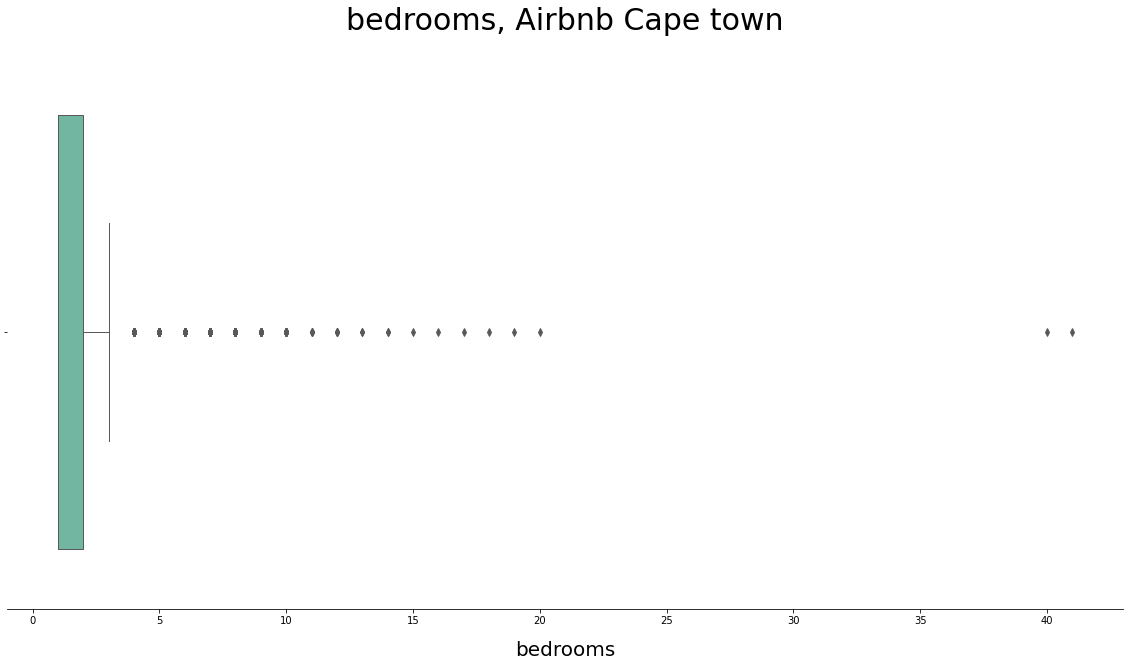

In [27]:
box_plot(listings_df['bedrooms']) # checking if there are outliers in the bedrooms column

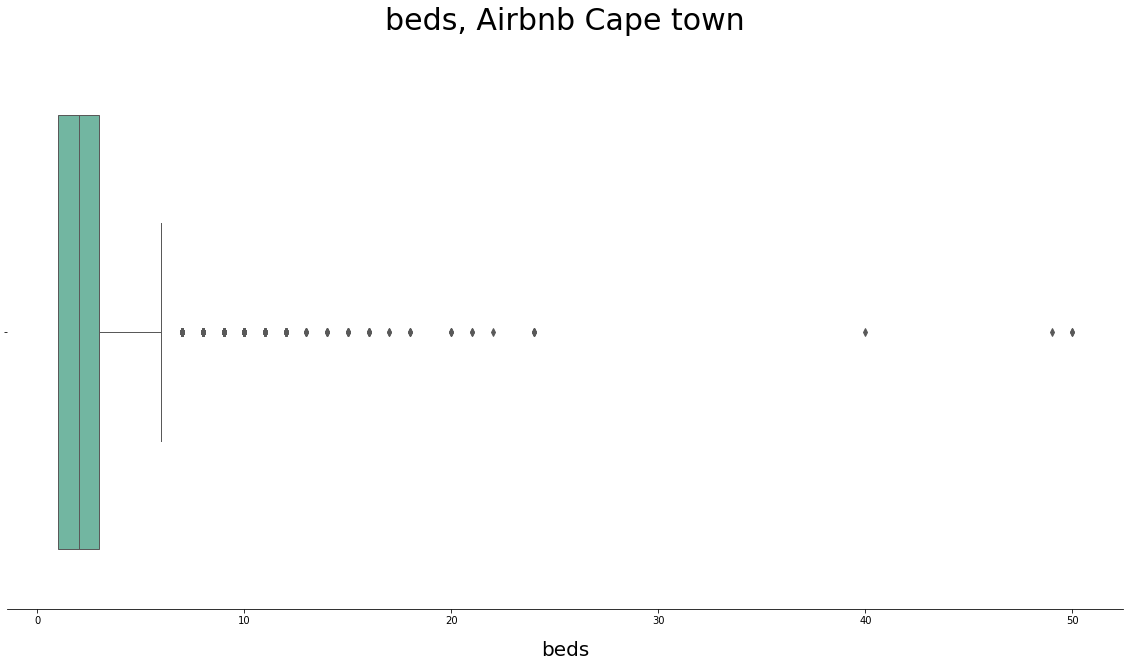

In [28]:
box_plot(listings_df['beds']) # checking if there are outliers in the bed column

In [29]:
# subsetting bedrooms extreme outliers

listings_df[listings_df['bedrooms'] >= 24][['bedrooms', 'beds', 'price', 'bathrooms_text']]

,bedrooms,beds,price,bathrooms_text
8401,41.0,50.0,"$1,689.00",1 bath
8966,40.0,50.0,$807.00,42 baths


In [30]:
# subsetting beds extreme outliers

listings_df[listings_df['beds'] >= 24][['bedrooms', 'beds', 'price', 'bathrooms_text']]

,bedrooms,beds,price,bathrooms_text
148,10.0,49.0,$840.00,32 baths
1742,12.0,24.0,"$3,361.00",2 baths
7064,12.0,24.0,"$9,800.00",6 baths
8401,41.0,50.0,"$1,689.00",1 bath
8966,40.0,50.0,$807.00,42 baths
12250,1.0,24.0,$350.00,1 shared bath
12517,14.0,24.0,$400.00,2 shared baths
12518,13.0,40.0,$686.00,9 baths


In [31]:
# dropping the extreme values in bedrooms and beds columns

print('Shape Before:', np.shape(listings_df))

listings_df = listings_df[listings_df['beds'] < 24].copy()
listings_df = listings_df[listings_df['bedrooms'] < 24].copy()

print('Shape After:', np.shape(listings_df))

Shape Before: (18903, 29)
Shape After: (17475, 29)


In [32]:
print(listings_df['bedrooms'].median()) # Checking the bedrooms median

listings_df['bedrooms'].fillna(value=listings_df['bedrooms'].median(), inplace=True) # fill missing values

1.0


In [33]:
print(listings_df['beds'].median()) # Checking the beds median

listings_df['beds'].fillna(value=listings_df['beds'].median(), inplace=True) # fill missing values

2.0


##### bathrooms_text 

In [34]:
listings_completeness[listings_completeness['Feature'] == 'beds'] # checkings bathrooms_text completeness

,Feature,%_completeness
10,beds,98.5


In [35]:
listings_df['bathrooms_text'].head() # viewing bathrooms_text

0     1 bath
1     1 bath
2     1 bath
3     1 bath
4    2 baths
Name: bathrooms_text, dtype: object

In [36]:
listings_df['bathrooms_text'].unique()[:10] # checking bathrooms unique values

array(['1 bath', '2 baths', '1.5 baths', '5 baths', '3 baths',
       '3.5 baths', '1 private bath', '6.5 baths', '2.5 baths',
       '4.5 baths'], dtype=object)

This should be a categorical column.

In [37]:
# strip the substring alphabets, changing column to float

listings_df['bathrooms_text'] = listings_df['bathrooms_text'].str.extract('(\d+\.?\d*)')

listings_df['bathrooms_text'] = listings_df['bathrooms_text'].astype('float') # changing data type

listings_df['bathrooms_text'].value_counts()[:5]

1.0    8978
2.0    3574
1.5    1405
3.0     892
2.5     852
3.5     558
4.0     330
4.5     282
5.0     144
Name: bathrooms_text, dtype: int64

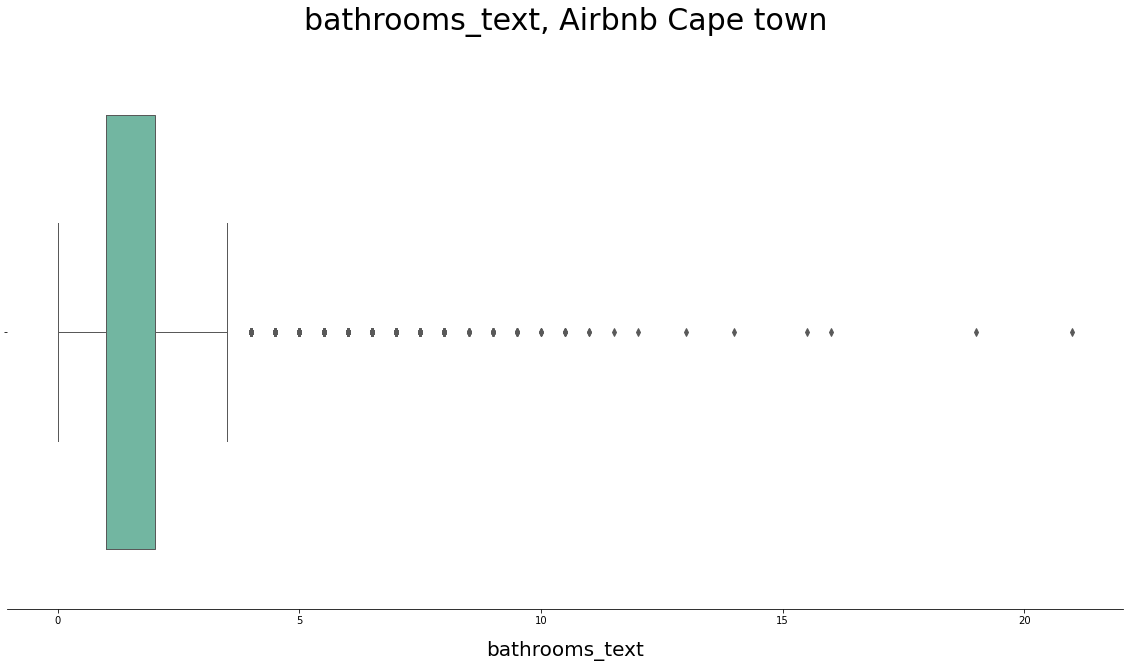

In [38]:
box_plot(listings_df['bathrooms_text']) # checking if there are outliers in bathrooms_text

In [39]:
print(listings_df['bathrooms_text'].median()) # Checking the bedrooms median

listings_df['bathrooms_text'].fillna(value=listings_df['bathrooms_text'].median(), inplace=True) # fill missing values

1.0


In [40]:
# changing column name 
listings_df.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

##### host_location

In [41]:
listings_completeness[listings_completeness['Feature'] == 'host_location'] # checking completeness

,Feature,%_completeness
11,host_location,99.52


In [42]:
# checking unique values

print('host_location unique counts are:', listings_df['host_location'].nunique())
print()
print(listings_df['host_location'].unique()[:10])

host_location unique counts are: 614

['Cape Town, Western Cape, South Africa'
 'Stellenbosch, Western Cape, South Africa' 'Western Cape, South Africa'
 'Windmeul, Western Cape, South Africa' 'ZA'
 'Johannesburg, Gauteng, South Africa' 'Sandton, Gauteng, South Africa'
 'Gibraltar' 'Las Vegas, Nevada, United States'
 "Betty's Bay, Western Cape, South Africa"]


This column is contains names of locations of the host. Areas outside Western Cape are, South Africa are present in it. 

From the data dictionary, this column contains locations of hosts as self reported. 

This can be used to analyse if there is a relation between host_location(proximity) to response_rate.

##### some 'host' columns

Dealing with host_response_time, host_response_rate & host_acceptance_rate columns.

In [43]:
# host_response_time
listings_completeness[listings_completeness['Feature'] == 'host_response_time'] # checking completeness

,Feature,%_completeness
7,host_response_time,77.82


In [44]:
# checking unique counts

print('host_response_time unique counts are:', listings_df['host_response_time'].nunique())
print()
print(listings_df['host_response_time'].unique())

host_response_time unique counts are: 4

['within an hour' 'within a few hours' nan 'within a day'
 'a few days or more']


We see that the host_response_time is a categorical column. It also has missing values. We will impute 'unknown' category as a category in this column.

In [45]:
listings_df['host_response_time'] = listings_df['host_response_time'].fillna('unknown') # filling nan values with unknown

In [46]:
# host_response_rate
listings_completeness[listings_completeness['Feature'] == 'host_response_rate'] # viewing host response rate completeness

,Feature,%_completeness
6,host_response_rate,77.82


Approx 22% of data is missing.

In [47]:
# creating a series of host response rate

host_response_rate = listings_df['host_response_rate'].copy()

print('host_response_rate unique counts are:', host_response_rate.nunique())
print()
print(host_response_rate.unique()[:10]) # checking unique values 

host_response_rate unique counts are: 42

['100%' nan '50%' '80%' '87%' '67%' '75%' '33%' '90%' '70%']


In [48]:
listings_df['host_response_rate'] = strip_signs(listings_df, 'host_response_rate') # stripping % signs from the column

In [49]:
print(listings_df['host_response_rate'].median()) # checking the median 

100.0


The median is 100%. Is that the general trend?

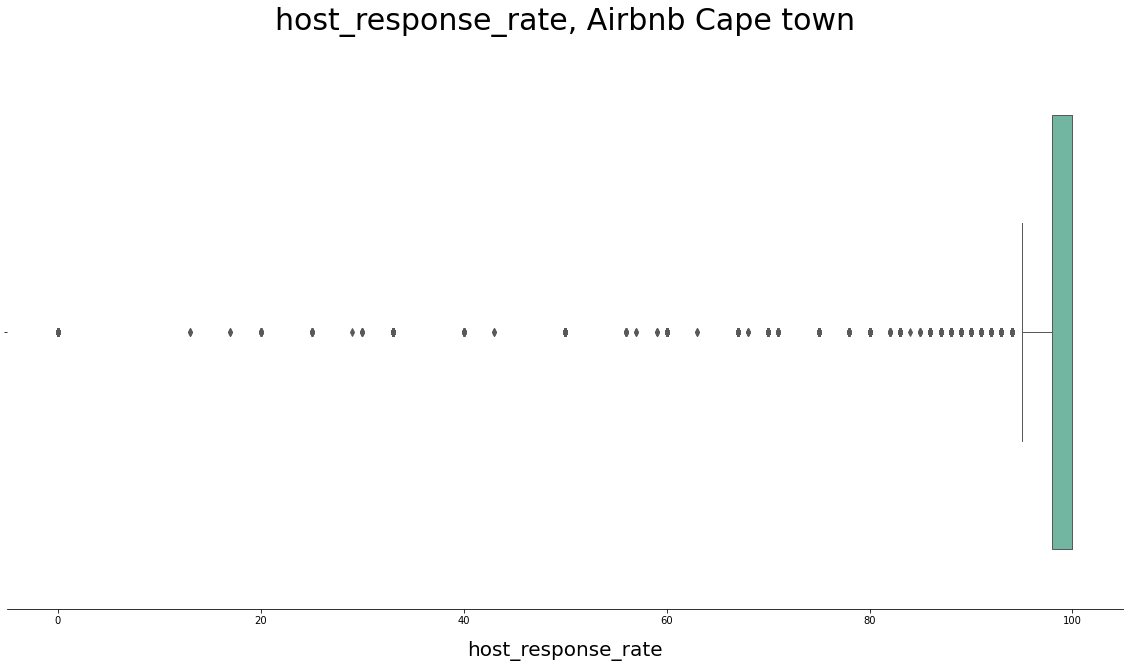

In [50]:
box_plot(listings_df['host_response_rate']) # boxplot of host_response_rate

It is okay to fill missing values with the median.

In [51]:
listings_df['host_response_rate'].fillna(value=listings_df['host_response_rate'].median(), inplace=True) # filling missing values with median

In [52]:
# host_acceptance_rate
listings_completeness[listings_completeness['Feature'] == 'host_acceptance_rate'] # host_acceptance_rate

,Feature,%_completeness
8,host_acceptance_rate,87.51


Approx 13% of data is missing.

In [53]:
# checking unique values

print('host_acceptance_rate unique counts are:', listings_df['host_acceptance_rate'].nunique())
print()
print(listings_df['host_acceptance_rate'].unique()[:10])

host_acceptance_rate unique counts are: 87

['100%' '50%' '67%' '71%' nan '94%' '93%' '11%' '83%' '99%']


In [54]:
listings_df['host_acceptance_rate'] = strip_signs(listings_df, 'host_acceptance_rate') # stripping % signs from the column

In [55]:
print(listings_df['host_acceptance_rate'].median()) # checking the median 

95.0


The median is 95%. Is that the general trend?

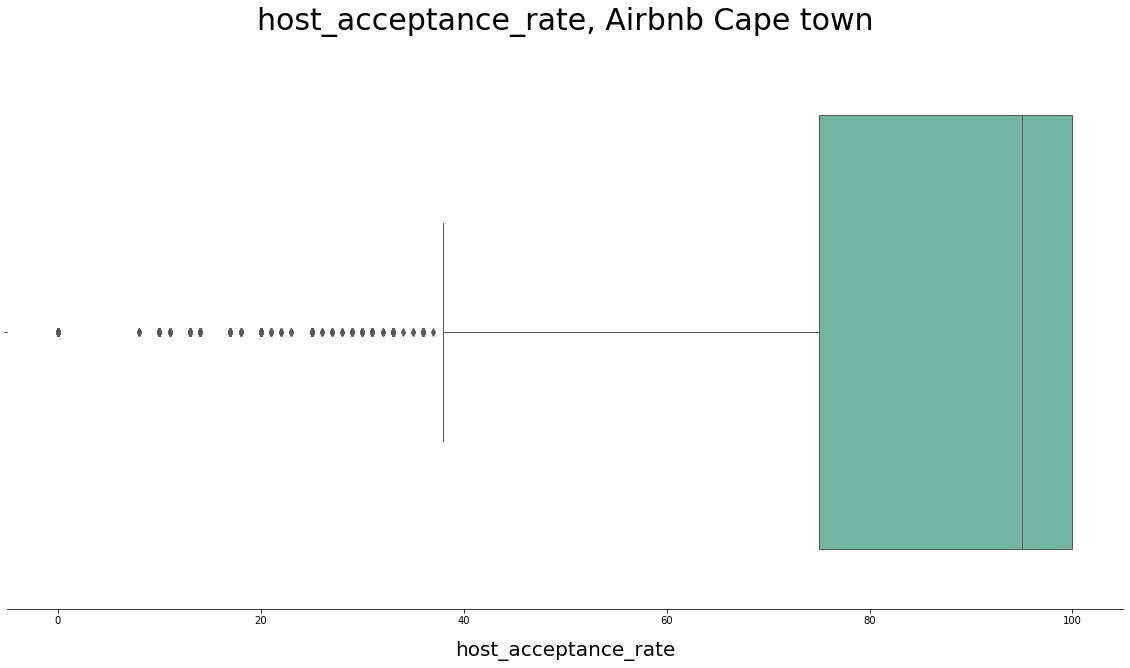

In [56]:
box_plot(listings_df['host_acceptance_rate']) # boxplot of host_acceptance rate

It is okay to fill missing values with the median.

In [57]:
# filling missing values with median

listings_df['host_acceptance_rate'].fillna(value=listings_df['host_acceptance_rate'].median(), inplace=True)

acceptance rate and response rate need to be transformed to categorical variables. To do that rounding off of the values is to be done.

In [58]:
# rounding off the values
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].apply(lambda x: round(x, -1))
listings_df['host_response_rate'] = listings_df['host_response_rate'].apply(lambda x: round(x, -1))

##### Other host columns

Dealing with host_name, host_since, host_identity_verified, host_is_superhost, host_has_profile_pic, host_picture_url, host_listings_count & host_total_listings_count columns.

In [59]:
# making a list of columns containing 'host' in their names, that haven't been dealt with

already_dealt = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_location']

rem_host_cols = [column for column in listings_df.columns if 'host' in column.strip() and column not in already_dealt]
host_traits = [column for column in rem_host_cols if column in list(listings_completeness['Feature'])]

host_traits

['host_since', 'host_is_superhost']

In [60]:
# host_acceptance_rate
listings_completeness[listings_completeness['Feature'].isin(host_traits)] # host_acceptance_rate

,Feature,%_completeness
13,host_since,99.99
14,host_is_superhost,99.99


In [61]:
listings_df[host_traits].head() # viewing the host columns

,host_since,host_is_superhost
0,2016-10-07,f
1,2012-08-29,f
2,2016-10-07,f
3,2016-02-11,f
4,2016-02-11,f


The host_since column contains dates about the date in which a host has been a host. The values in this column will be sliced, and only the year will be left. The column will also be transformed into a integer data type.

In [62]:
listings_df['host_since'].isna().sum() # sum of nan values in host_since

1

In [63]:
listings_df[listings_df['host_is_superhost'].isna()][host_traits]

,host_since,host_is_superhost
6909,NaN,NaN


In [64]:
listings_df.dropna(subset= ["host_since"], inplace= True) # Dropping null row 

listings_df['host_since'] = listings_df['host_since'].apply(lambda x: x[:4]) # slicing the column

listings_df['host_since'] = listings_df['host_since'].astype(int) # changing column to int

host is superhost needs to be transformed into a boolean data type

In [65]:
# listings_df['host_is_superhost'] = listings_df['host_is_superhost'].astype('bool')

In [66]:
# repacing values to make column a bool dtype
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].replace({'t': True, 'f': False})

##### Current dataframe info after cleaning is:**

In [67]:
percentage_completeness(listings_df)[:3] # current completeness

,Feature,%_completeness
0,host_location,99.51
1,id,100.00
2,review_scores_location,100.00


In [68]:
# pd.DataFrame(listings_df.groupby('host_response_time')['host_response_rate'].nunique())

#### 4.1.1.2 Remaining columns

##### amenities

In [69]:
listings_df['amenities'].head() # viewing amenities column

0    ["Hot water", "Cooking basics", "Iron", "Free ...
1    ["Hot water", "Cooking basics", "Iron", "Dryin...
2    ["TV", "Long term stays allowed", "Cooking bas...
3    ["TV", "Gym", "Long term stays allowed", "Heat...
4    ["TV", "Long term stays allowed", "Heating", "...
Name: amenities, dtype: object

In [70]:
# Splitting amenities column and get amenities count words
# then creating a new column "amenities_count"

# listings_df['amenities_count'] = listings_df['amenities'].str.split(',').str.len()
# # tramsform amenities records from list to string type
# # listings_df.amenities = listings_df['amenities'].str.replace("[{}]", "").str.replace('"', "").str.replace('[',"").str.replace(']',"")
 
letters = string.ascii_letters

amenities_split = listings_df['amenities'].apply(lambda x: x.split('"'))
new_amenities = []

for split in amenities_split:
    res = [x for x in split if x[0] in letters]
    new_amenities.append(res)

listings_df['amenities'] = new_amenities
listings_df['amenities_count'] = listings_df['amenities'].apply(lambda x: len(x))

In [105]:
listings_df['amenities'][2]

['TV',
 'Long term stays allowed',
 'Cooking basics',
 'Kitchen',
 'Iron',
 'Essentials',
 'Free parking on premises',
 'Pool',
 'Wifi',
 'Hair dryer']

In [103]:
listings_df['amenities_count'].nunique()

81

##### location columns

Dealing with latitude & longitude 

In [73]:
# To DO!!!

**Testing location filler.**

In [74]:
# listings_df[['longitude', 'latitude']].head()

In [75]:
# v= rg.search((-34.03149, 18.82689))

In [76]:
# type(v)

In [77]:
# v[0]["admin2"]

In [78]:
# test["municipal"] = rg.search((test.latitude, test.longitude))
# test.head()

In [79]:
# location_df = listings_df[['latitude', 'longitude']]

# # def locate(test, "latitude", "longitude"):
# #   location = rg.search((test["latitude"][0], test["longitude"][0]))
# #   return location[0]["admin2"]

# location_df.head()

##### last_scraped & hosting_age feature engineering

In [80]:
# viewing 'scrape' columns
listings_df['last_scraped'].head() 

0    2022-06-22
1    2022-06-22
2    2022-06-22
3    2022-06-22
4    2022-06-22
Name: last_scraped, dtype: object

In [81]:
# slicing the year from last scraped
listings_df['last_scraped'] = listings_df['last_scraped'].apply(lambda x: x[:4]) 
# changing column data type
listings_df['last_scraped'] = listings_df['last_scraped'].astype(int) 

In [82]:
# creating a column to show age of the host
listings_df['hosting_age'] = listings_df['last_scraped'] - listings_df['host_since']
# dropping last_scrapped and host_since columns
listings_df.drop(columns= ['last_scraped', 'host_since'], inplace= True) 

##### room_type & accomodates columns

In [83]:
# viewing the columns
listings_df[['room_type', 'accommodates']].head() 

,room_type,accommodates
0,Entire home/apt,2
1,Entire home/apt,4
2,Entire home/apt,2
3,Entire home/apt,2
4,Entire home/apt,4


In [84]:
# checking unique values in room type column

print('The unique values in room_type column ', listings_df['room_type'].nunique())
print('-'*100)
listings_df['room_type'].unique()[:5]

The unique values in room_type column  4
----------------------------------------------------------------------------------------------------


array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [85]:
# checking unique values in room type column

print('The unique values in accommodates column ', listings_df['accommodates'].nunique())
print('-'*100)
listings_df['accommodates'].unique()[:5]

The unique values in accommodates column  16
----------------------------------------------------------------------------------------------------


array([ 2,  4, 10,  6,  5])

In [86]:
print('The max number a listing can accommodate ', listings_df['accommodates'].max()) # maximum accommodates 
print('The min number a listing can accommodate ', listings_df['accommodates'].min()) # minimum accommodates

The max number a listing can accommodate  16
The min number a listing can accommodate  1


##### instant_bookable

In [101]:
listings_df['instant_bookable'].value_counts()

False    9805
True     7669
Name: instant_bookable, dtype: int64

In [88]:
# repacing values to make column a bool dtype
listings_df['instant_bookable'] = listings_df['instant_bookable'].replace({'t': True, 'f': False})

In [130]:
# checking the unique counts of the features in the dataframe
unique_count = []

for column in list(listings_df.columns):
    if column != 'amenities': # because list type is not hashable
        unique_val = listings_df[column].nunique()
        unique_count.append(unique_val)

    else: 
        unique_count.append('list_type')

pd.DataFrame(list(zip(list(listings_df.columns), unique_count)), columns=['feature', 'unique_count'])

,feature,unique_count
0,id,17474
1,listing_url,17474
2,host_url,9429
3,host_location,614
4,neighbourhood_cleansed,91
5,host_response_time,5
6,host_response_rate,11
7,host_acceptance_rate,11
8,host_is_superhost,2
9,latitude,12181


With cleaning finished. A reset of the dataframe index is needed.

In [128]:
listings_df.reset_index(drop=True, inplace=True)